In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#  Loading Data

path = "./PS_20174392719_1491204439457_log.csv"
load_data = pd.read_csv(path)


In [3]:
# Menampilkan 5 baris data

df=pd.DataFrame(load_data)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Note:

- **step** : Merepresentasikan unit waktu di dunia nyata. Dalam kasus ini, 1 step adalah 1 jam waktu. Total step adalah 744 (simulasi 30 hari).
- **type** : Jenis transaksi, yaitu **CASH-IN**, **CASH-OUT**, **DEBIT**, **PAYMENT**, dan **TRANSFER**.
- **amount** : Jumlah transaksi 
- **nameOrig** : Pelanggan yang memulai transaksi.
- **oldbalanceOrg** : Saldo awal sebelum transaksi dilakukan.
- **newbalanceOrig** : Saldo baru setelah transaksi dilakukan.
- **nameDest** : Pelanggan yang menjadi penerima transaksi.
- **oldbalanceDest** : Saldo awal penerima sebelum transaksi. 
- **newbalanceDest** : Saldo baru penerima setelah transaksi.
- **isFraud** : Mengkategorikan transaksi, jika penipuan (1) dan bukan penipuan (0)
- **isFlaggedFraud** : mengkategorikan upaya ilegal, jika mentransfer lebih dari 200.000 dalam satu transaksi maka dalam pengawasan (1) dan jika dibawahnya maka bukan pengawasan (0)



In [4]:
# Mengecek jumlah baris & kolom
df.shape

(6362620, 11)

In [5]:
# Mengecek informasi data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Note:
- Jumlah data (rows) : 6362620
- Jumlah kolom : 11
- tipe data bertipe 'int64' : 3 (step, isFraud, isFlaggedFraud)
- tipe data bertipe 'object' : 3 (type, nameOrig, nameDest)
- tipe data bertipe 'float64' : 5 (amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest)

In [6]:
# Mengecek jumlah null data

df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Note:
- Tidak terdapat nilai null pada keseluruhan data

In [7]:
# Mengecek duplikat

df.duplicated().sum()

np.int64(0)

Note: 
- Tidak terdapat data duplikat pada keseluruhan data

In [8]:
# Rename nama kolom

df = df.rename(columns = {'nameOrig' : 'nameOrig',
                          'type':'type',
                          'step': 'step',
                          'amount' : 'amount',
                          'oldbalanceOrg' : 'oldbalanceOrig',
                          'newbalanceOrig': 'newbalanceOrig', 
                          'nameDest' : 'nameDest',
                          'oldbalanceDest' : 'oldbalanceDest',
                          'newbalanceDest': 'newbalanceDest',
                          'isFraud' : 'isFraud',
                          'isFlaggedFraud':'isflaggedFraud'}
                          
                          )

Note:
- Mengganti nama kolom

| Nama Lama       | Nama Baru          |
|-----------------|--------------------|
| nameOrig        | nameOrig           |
| type            | type               |
| step            | step               |
| amount          | amount             |
| oldbalanceOrg   | oldbalanceOrig     |
| newbalanceOrig  | newbalanceOrig     |
| nameDest        | nameDest           |
| oldbalanceDest  | oldbalanceDest     |
| newbalanceDest  | newbalanceDest     |
| isFraud         | isFraud            |
| isFlaggedFraud  | isflaggedFraud     |



In [9]:
# Analisis statistik deskriptif

df.describe().round(1)


,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isflaggedFraud
count,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0
mean,243.4,179861.9,833883.1,855113.7,1100701.7,1224996.4,0.0,0.0
std,142.3,603858.2,2888242.7,2924048.5,3399180.1,3674128.9,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,156.0,13389.6,0.0,0.0,0.0,0.0,0.0,0.0
50%,239.0,74871.9,14208.0,0.0,132705.7,214661.4,0.0,0.0
75%,335.0,208721.5,107315.2,144258.4,943036.7,1111909.2,0.0,0.0
max,743.0,92445516.6,59585040.4,49585040.4,356015889.4,356179278.9,1.0,1.0


Note:
1. step
- Step 1 - 744 (total 30 hari simulasi)
2. amount
- Rata-rata nominal transaksi adalah 179.861
- Nominal transaksi terkecil adalah 0
- Nominal transaksi terbesar adalah 92.445.520
3. oldbalanceOrg (Saldo Awal Pengirim)
- Rata-rata saldo awal pengirim adalah 833.883
- saldo terkecil adalah 0
- saldo terbesar adalah 59.585.040
4. newbalanceOrig (Saldo Baru Pengirim)
- Rata-rata saldo baru pengirim setelah transaksi adalah 855.113
- saldo terkecil adalah 0
- saldo terbesar adalah 49.585.040
5. oldbalanceDest (Saldo Awal Penerima)
- Rata-rata saldo awal penerima adalah 1.110.702
- saldo terkecil adalah 0
- saldo terbesar adalah 356.019.308
6. newbalanceDest (Saldo Baru Penerima)
- Rata-rata saldo baru penerima adalah 1.224.996
- saldo terkecil adalah 0
- saldo terbesar adalah 356.179.300
7. isFraud
- Rata-rata nilai fraud adalah 0,00129 (0,129% ~ 0,13%)
8. isFlaggedFraud
- Rata-rata nilai isFlaggedFraud adalah 0,0000025 (0,00025%)




<Axes: title={'center': 'Pearson Corelation'}>

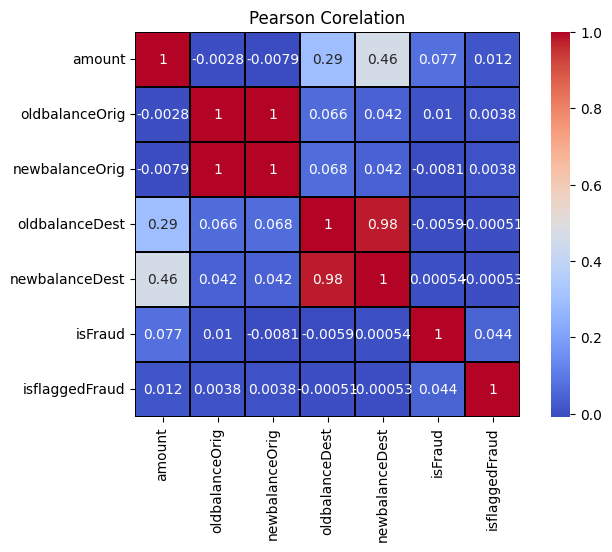

In [10]:
# Memeriksa korelasi variabel

df_cor = df[['amount', 'oldbalanceOrig', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isflaggedFraud']]
f,ax= plt.subplots(figsize=(8,5))
plt.title("Pearson Corelation")
sns.heatmap(df_cor.astype(float).corr(), linewidth=0.25, vmax=1.0, square=True, cmap="coolwarm", linecolor='black', annot=True)

Note:
- oldbalanceOrig vs newbalanceOrig: Korelasi sempurna (1), menunjukkan hubungan linear penuh.
- oldbalanceDest vs newbalanceDest: Korelasi hampir sempurna (0.98), menunjukkan hubungan langsung yang sangat kuat.
- amount vs newbalanceDest: Korelasi sedang (0.46), menunjukkan bahwa jumlah transaksi memengaruhi saldo penerima.
- amount vs isFraud: Korelasi rendah (0.077), menunjukkan hubungan yang sangat lemah antara jumlah transaksi dan fraud.

# EDA

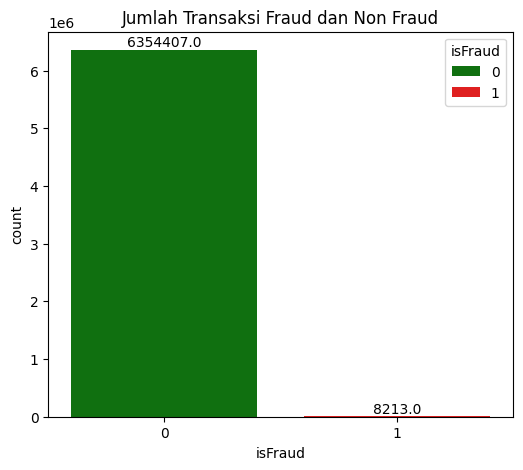

In [102]:
# Distribusi jumlah transaksi berdasarkan "isfraud"

plt.figure(figsize=(6,5))
ax = sns.countplot(data=df, x="isFraud", hue="isFraud", palette=['green','red'])
plt.title("Jumlah Transaksi Fraud dan Non Fraud")

for p in ax.patches:
    if p.get_height() > 10: 
        ax.annotate(
            '{:.1f}'.format(p.get_height()), 
            (p.get_x() + p.get_width() / 2., p.get_height() + 5000), 
            ha='center', va='bottom'
        )

plt.show()

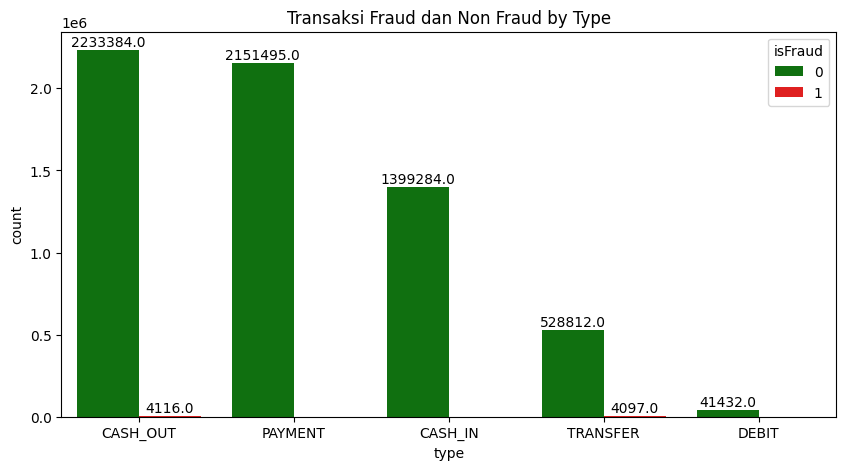

In [103]:
# Distribusi jumlah transaksi berdasarkan "type" dengan kategori "isfraud"

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x="type", hue="isFraud", palette=['green','red'], order=['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'])
plt.title("Transaksi Fraud dan Non Fraud by Type")

for p in ax.patches:
    if p.get_height() > 10: 
        ax.annotate(
            '{:.1f}'.format(p.get_height()), 
            (p.get_x() + p.get_width() / 2., p.get_height() + 5000), 
            ha='center', va='bottom'
        )

plt.show()


Note:
- Transaksi yang terdapat fraud hanyalah jenis CASH_OUT dan TRANSFER dengan masing-masing 4116 dan 4097

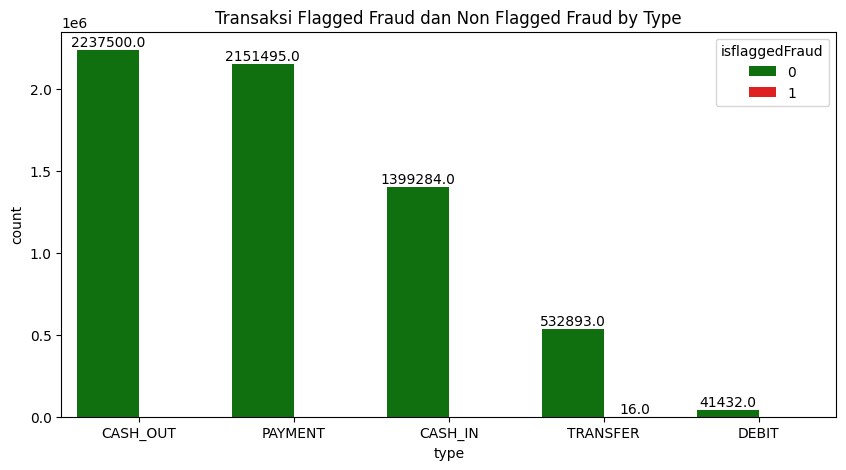

In [104]:
# Distribusi jumlah transaksi berdasarkan "type" dengan kategori "isflaggedfraud"

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x="type", hue="isflaggedFraud", palette=['green','red'], order=['CASH_OUT', 'PAYMENT', 'CASH_IN', 'TRANSFER', 'DEBIT'])
plt.title("Transaksi Flagged Fraud dan Non Flagged Fraud by Type")

for p in ax.patches:
    if p.get_height() > 10: 
        ax.annotate(
            '{:.1f}'.format(p.get_height()), 
            (p.get_x() + p.get_width() / 2., p.get_height() + 5000), 
            ha='center', va='bottom'
        )

plt.show()

Note:
- Transaksi yang terdapat flagged fraud hanyalah jenis  TRANSFER sebanyak 16 transaksi

In [13]:
Transaksi_upper_200k = df[(df["amount"] > 200000) & (df["type"] == "TRANSFER")]
print("Transaksi yang diduga 'flagged': ",len(Transaksi_upper_200k))

Transaksi yang diduga 'flagged':  409110


Note:
- Transaksi yang diduga 'flagged' :  409.110, sehingga feature/kolom 'isflaggedFraud' tidak memuat informasi yang akurat


In [14]:
df.amount.sum()

np.float64(1144392944759.77)

Note:
- Total keseluruhan transaksi: 1144.392.944.759.77 (Satu kuadriliun seratus empat puluh empat triliun tiga ratus sembilan puluh dua miliar sembilan ratus empat puluh empat juta tujuh ratus lima puluh sembilan ribu tujuh ratus tujuh puluh rupiah)

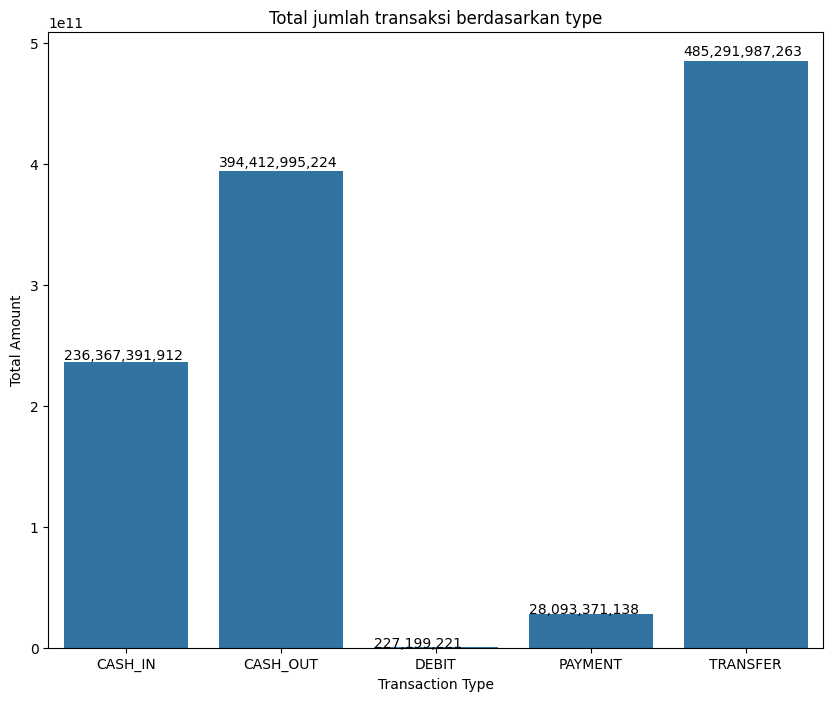

In [15]:
# Total keseluruhan jumlah uang yang transaksikan berdasarkan type

d = df.groupby('type')['amount'].sum()
plt.figure(figsize=(10,8))
ax = sns.barplot(x=d.index,y=d.values)
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x()+0, p.get_height()*1.01))
    
plt.title("Total jumlah transaksi berdasarkan type")
plt.xlabel("Transaction Type")
plt.ylabel("Total Amount")
plt.show()

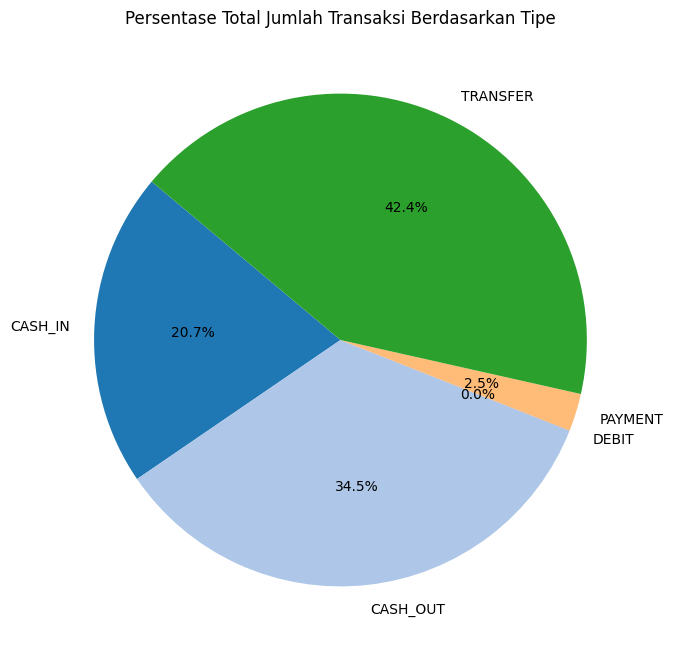

In [16]:
# Data transaksi berdasarkan tipe
transaction_types = ['CASH_IN', 'CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']
transaction_amounts = [236367391912, 394412995224, 227199221, 28093371138, 485291987263]

# Total transaksi keseluruhan
total_transactions = sum(transaction_amounts)

# Hitung persentase masing-masing tipe
transaction_percentages = [(amount / total_transactions) * 100 for amount in transaction_amounts]

# Membuat diagram lingkar
plt.figure(figsize=(8, 8))
plt.pie(transaction_percentages, labels=transaction_types, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title("Persentase Total Jumlah Transaksi Berdasarkan Tipe")
plt.show()


Note:

- Total Jumlah Transaksi Berdasarkan Tipe

1. **CASH_IN**: 236,367,391,912 - 20.7% 
(Dua ratus tiga puluh enam miliar tiga ratus enam puluh tujuh juta tiga ratus sembilan puluh satu ribu sembilan ratus dua belas)

2. **CASH_OUT**: 394,412,995,224 - 34.5% 
(Tiga ratus sembilan puluh empat miliar empat ratus dua belas juta sembilan ratus sembilan puluh lima ribu dua ratus dua puluh empat)

3. **DEBIT**: 227,199,221 - 0.0% 
(Dua ratus dua puluh tujuh juta seratus sembilan puluh sembilan ribu dua ratus dua puluh satu)

4. **PAYMENT**: 28,093,371,138 - 34.5%  
(Dua puluh delapan miliar sembilan puluh tiga juta tiga ratus tujuh puluh satu ribu seratus tiga puluh delapan)

5. **TRANSFER**: 485,291,987,263 - 42.4%  
(Empat ratus delapan puluh lima miliar dua ratus sembilan puluh satu juta sembilan ratus delapan puluh tujuh ribu dua ratus enam puluh tiga)
- CASH_OUT dan TRANSFER adalah 879,704,982 - 76.9% 
(Delapan ratus tujuh puluh sembilan miliar tujuh ratus empat juta sembilan ratus delapan puluh dua ribu empat ratus delapan puluh tujuh)

<Axes: xlabel='type', ylabel='amount'>

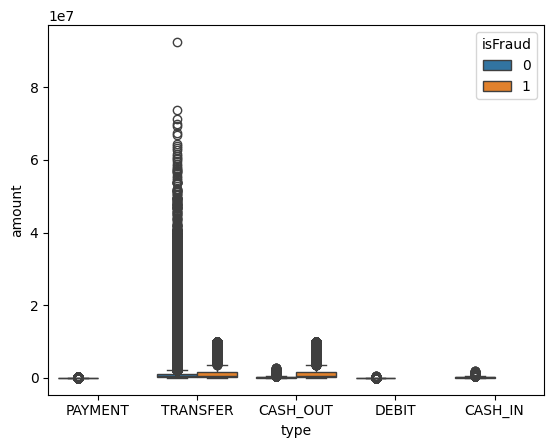

In [17]:
sns.boxplot(data=df, x="type", y="amount", hue="isFraud")

Note:
- Terdapat banyak outlier pada type transaksi transfer
- Fraud lebih sering terjadi pada transaksi dengan nilai besar dalam TRANSFER dan CASH_OUT

# Feature Engineering

In [18]:
# Membuat kolom type2, yaitu backround pengirim dan penerima (Customer atau Merchant)

data = df
data['type2'] = np.nan
data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'
data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'), 'type2'] = 'CM'
data.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MC'
data.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'), 'type2'] = 'MM'

C:\Users\burv\AppData\Local\Temp\ipykernel_18792\518633604.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CC' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'), 'type2'] = 'CC'


In [19]:
# Mengubah posisi kolom type2

new_order = [
    'step','type', 'type2', 'amount', 'nameOrig', 'oldbalanceOrig', 
    'newbalanceOrig', 'nameDest', 'oldbalanceDest', 
    'newbalanceDest', 'isFraud', 'isflaggedFraud'
]

data = data[new_order]

In [20]:
# Dropping kolom

data.drop(columns = ['isflaggedFraud'], axis = 'columns', inplace = True)

C:\Users\burv\AppData\Local\Temp\ipykernel_18792\3533659821.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns = ['isflaggedFraud'], axis = 'columns', inplace = True)


Note:
- Kolom yang telah diseleksi atau akan digunakan

| No   | Nama Baru         | Deskripsi |
|------|-------------------|-----------|
| 1    | step             | Merepresentasikan unit waktu di dunia nyata. Dalam kasus ini, 1 step = 1 jam waktu. Total step = 744 (simulasi 30 hari). |
| 2    | type             | Jenis transaksi, yaitu **CASH-IN, CASH-OUT, DEBIT, PAYMENT, dan TRANSFER**. |
| 3    | type2            | Sub Jenis transaksi, yaitu **CC** (cutomer to customer) dan **CM** (cutomer to merchant). |
| 4    | nameOrig         | Pelanggan yang memulai transaksi. |
| 5    | amount           | Jumlah transaksi yang dilakukan. |
| 6    | oldbalanceOrg    | Saldo awal pengirim sebelum transaksi dilakukan. |
| 7    | newbalanceOrig   | Saldo baru pengirim setelah transaksi dilakukan. |
| 8    | nameDest         | Pelanggan yang menjadi penerima transaksi. |
| 9    | oldbalanceDest   | Saldo awal penerima sebelum transaksi dilakukan. |
| 10   | newbalanceDest   | Saldo baru penerima setelah transaksi dilakukan. |
| 11   | isFraud          | Mengkategorikan transaksi: **1 = penipuan, 0 = bukan penipuan**. |







In [21]:
data.head()

,step,type,type2,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,CM,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,CM,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,CC,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,CC,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,CM,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


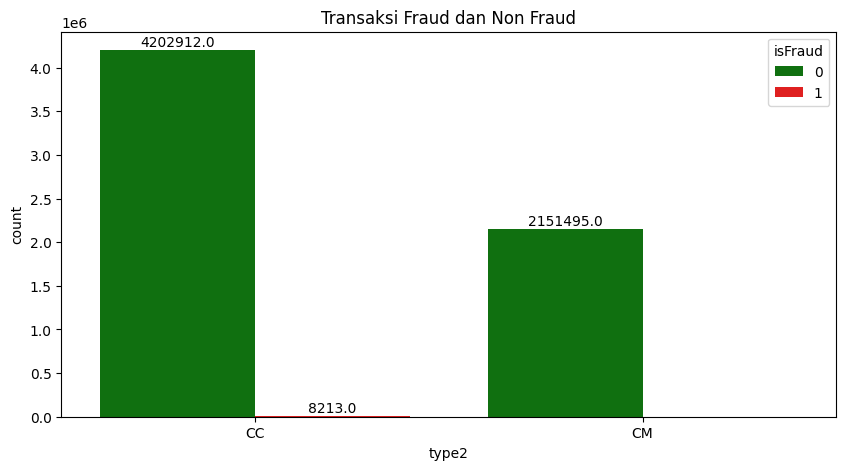

In [ ]:
# Distribusi jumlah transaksi berdasarkan "type2" dengan kategori "isfraud"

plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df, x="type2", hue="isFraud", palette=['green','red'], order=['CC','CM'])
plt.title("Transaksi Fraud dan Non Fraud")

for p in ax.patches:
    if p.get_height() > 10: 
        ax.annotate(
            '{:.1f}'.format(p.get_height()), 
            (p.get_x() + p.get_width() / 2., p.get_height() + 5000), 
            ha='center', va='bottom'
        )

plt.show()

In [23]:
fraud_trans = data[data['isFraud'] == 1]
valid_trans = data[data['isFraud'] == 0]

print('Jumlah transaksi fraud menurut jenisnya (type2):\n', fraud_trans.type2.value_counts(), '\n')
print('Jumlah transaksi valid menurut jenisnya (type2):\n', valid_trans.type2.value_counts())

Jumlah transaksi fraud menurut jenisnya (type2):
 type2
CC    8213
Name: count, dtype: int64 

Jumlah transaksi valid menurut jenisnya (type2):
 type2
CC    4202912
CM    2151495
Name: count, dtype: int64


In [24]:
print("Ambang batas tertinggi transaksi fraud: ",fraud_trans.amount.max())
print("Ambang batas tertinggi transaksi valid: ",valid_trans.amount.max())

Ambang batas tertinggi transaksi fraud:  10000000.0
Ambang batas tertinggi transaksi valid:  92445516.64


In [25]:
print("Ambang batas terendah transaksi fraud: ",fraud_trans.amount.min())
print("Ambang batas terendah transaksi valid: ",valid_trans.amount.min())

Ambang batas terendah transaksi fraud:  0.0
Ambang batas terendah transaksi valid:  0.01


In [26]:
print("Ambang batas rata-rata transaksi fraud: ",fraud_trans.amount.mean())
print("Ambang batas rata-rata transaksi valid: ",valid_trans.amount.mean())

Ambang batas rata-rata transaksi fraud:  1467967.299140387
Ambang batas rata-rata transaksi valid:  178197.04172740763


Note:

1. **Jumlah Transaksi Berdasarkan Jenisnya (`type2`)**:
   - Untuk **fraud_trans**:
     - Jenis `CC`: 8.213 transaksi.
   - Untuk **valid_trans**:
     - Jenis `CC`: 4.202.912 transaksi.
     - Jenis `CM`: 2.151.495 transaksi.

2. **Ambang Batas Tertinggi Transaksi**:
   - **Transaksi Fraud**:
     - Nilai transaksi tertinggi: **10.000.000.0**.
   - **Transaksi Valid**:
     - Nilai transaksi tertinggi: **9.244.5516.64**.

3. **Ambang Batas Terendah Transaksi**:
   - **Transaksi Fraud**:
     - Nilai transaksi terendah: **0.0**.
   - **Transaksi Valid**:
     - Nilai transaksi terendah: **0.01**.

4. **Rata-Rata Nilai Transaksi**:
   - **Transaksi Fraud**:
     - Rata-rata nilai transaksi: **1.467.967,29**.
   - **Transaksi Valid**:
     - Rata-rata nilai transaksi: **178.197,04**.


Text(0.5, 1.0, 'Sebaran jumlah uang transaksi fraud')

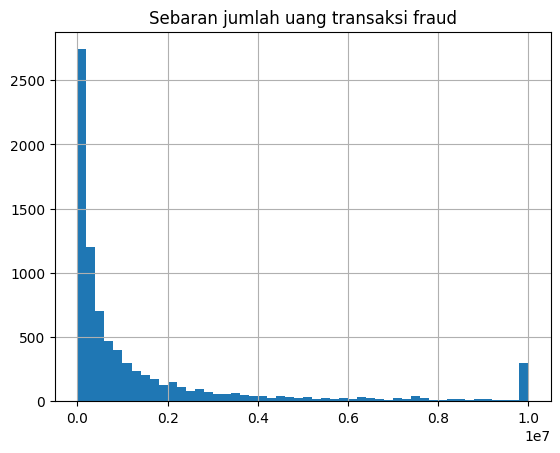

In [27]:
data[data['isFraud']==1]['amount'].hist(bins=50)
plt.title('Sebaran jumlah uang transaksi fraud')

Note:

1. Distribusi Positif Skewed (Right-Skewed)

- Mayoritas transaksi fraud terjadi dalam jumlah kecil, terlihat dari puncak tinggi di sisi kiri grafik.
- Beberapa transaksi memiliki jumlah yang sangat besar, terlihat dari ekor panjang di sisi kanan grafik.

2. Outlier atau Anomali

- Ada beberapa lonjakan kecil di bagian kanan grafik yang mungkin menunjukkan transaksi fraud dengan jumlah yang sangat besar.


Text(0.5, 1.0, 'Sebran jumlah uang transaksi valid')

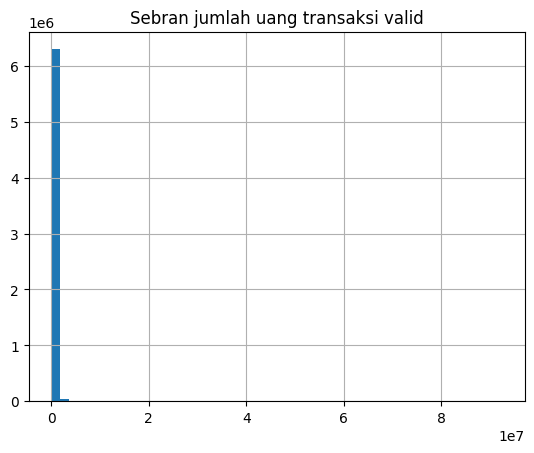

In [28]:
data[data['isFraud']==0]['amount'].hist(bins=50)
plt.title('Sebran jumlah uang transaksi valid')

Note:
1. Distribusi Positif Skewed (Right-Skewed)
- Mayoritas transaksi valid memiliki jumlah uang kecil, terlihat dari puncak tinggi di sisi kiri grafik.

# Visualization

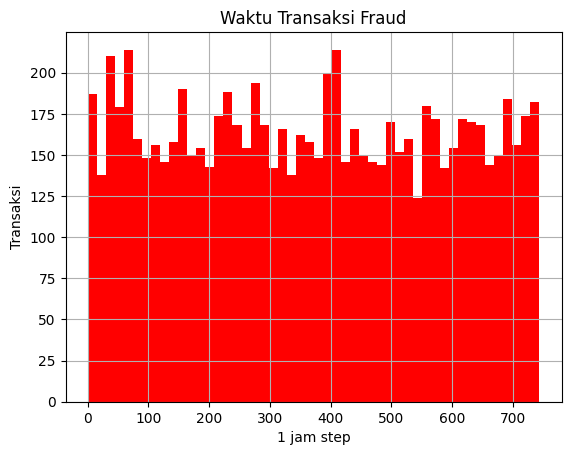

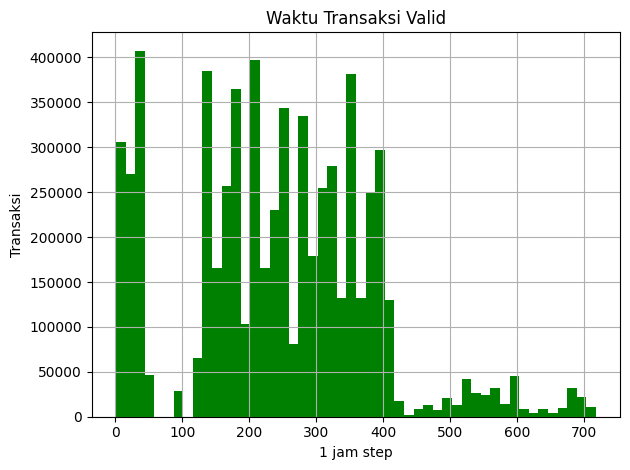

In [29]:
# Time patterns

bins = 50

fraud_trans.hist(column ="step",color="red",bins=bins)
plt.xlabel("1 jam step")
plt.ylabel("Transaksi")
plt.title("Waktu Transaksi Fraud")

valid_trans.hist(column="step",color="green",bins=bins)
plt.xlabel("1 jam step")
plt.ylabel("Transaksi")
plt.title("Waktu Transaksi Valid")

plt.tight_layout()
plt.show()

Note:

- Transaksi fraud terjadi disemua waktu
- Transaksi valid terjadi hanya pada waktu tertentu 
    - step 0-50 dan 120-400 dengan frekuensi tinggi
    - step 430-700 dengan frekuensi rendah

In [30]:
# Mendapatkan jam dan hari dalam seminggu

num_days = 7
num_hours = 24
fraud_days = fraud_trans.step % num_days
fraud_hours = fraud_trans.step % num_hours
valid_days = valid_trans.step % num_days
valid_hours = valid_trans.step % num_hours
all_days = data.step % num_days
all_hours = data.step % num_hours



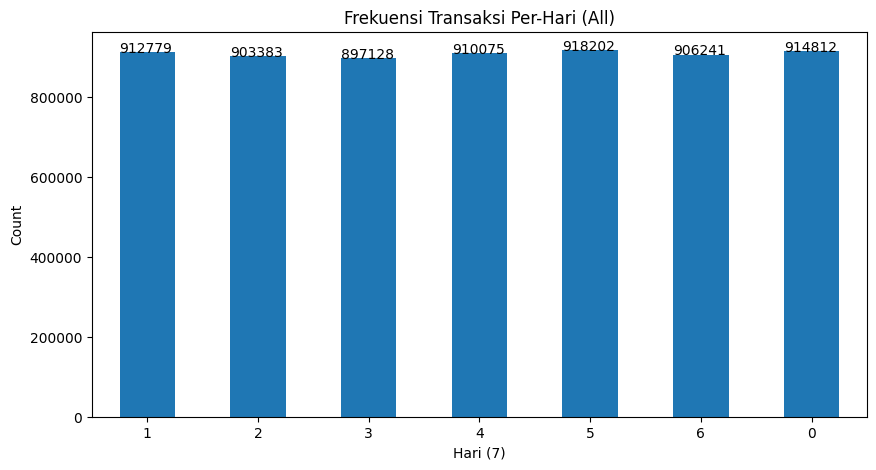

In [31]:
# Distribusi Frekuensi Transaksi Per-Hari (All)

plt.figure(figsize=(10,5))
ax = all_days.value_counts(sort=False).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))
plt.xlabel('Hari (7)')
plt.xticks( rotation=0)
plt.ylabel('Count')
plt.yticks()
plt.title('Frekuensi Transaksi Per-Hari (All)')
plt.show()

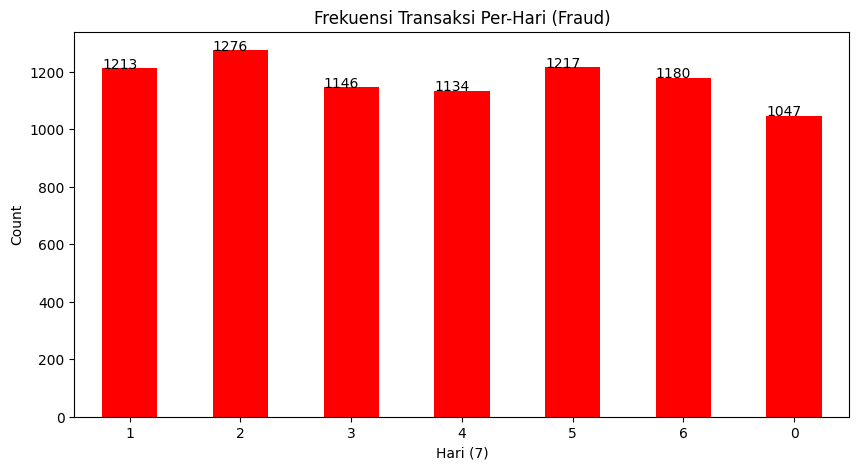

In [32]:
# Distribusi Frekuensi Transaksi Per-Hari (Fraud)

plt.figure(figsize=(10,5))
ax = fraud_days.value_counts(sort=False).plot(kind='bar', color='red')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))
plt.xlabel('Hari (7)')
plt.xticks( rotation=0)
plt.ylabel('Count')
plt.yticks()
plt.title('Frekuensi Transaksi Per-Hari (Fraud)')
plt.show()

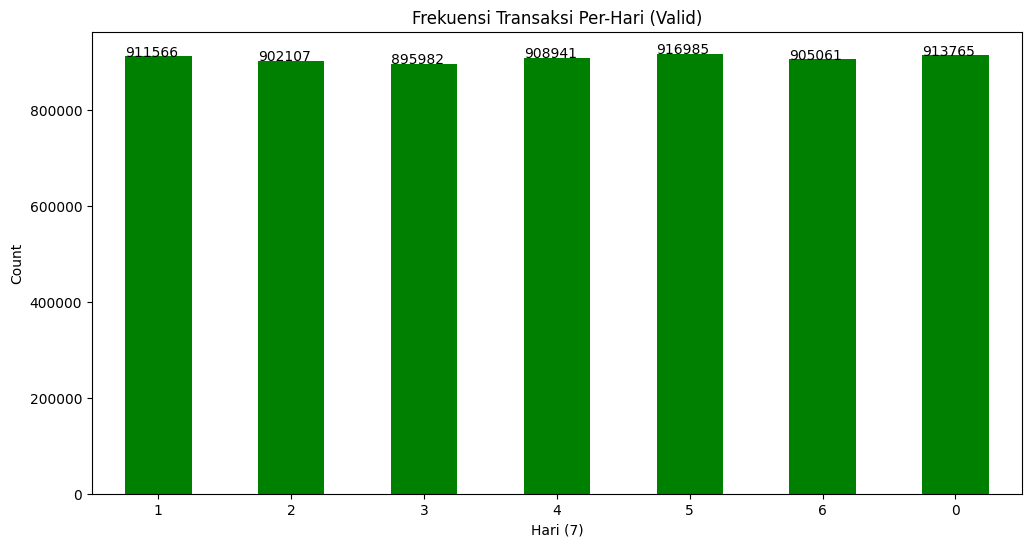

In [33]:
# Distribusi Frekuensi Transaksi Per-Hari (Valid)

plt.figure(figsize=(12,6))
ax = valid_days.value_counts(sort=False).plot(kind='bar',  color='green')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))
plt.xlabel('Hari (7)')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yticks()
plt.title('Frekuensi Transaksi Per-Hari (Valid)')
plt.show()

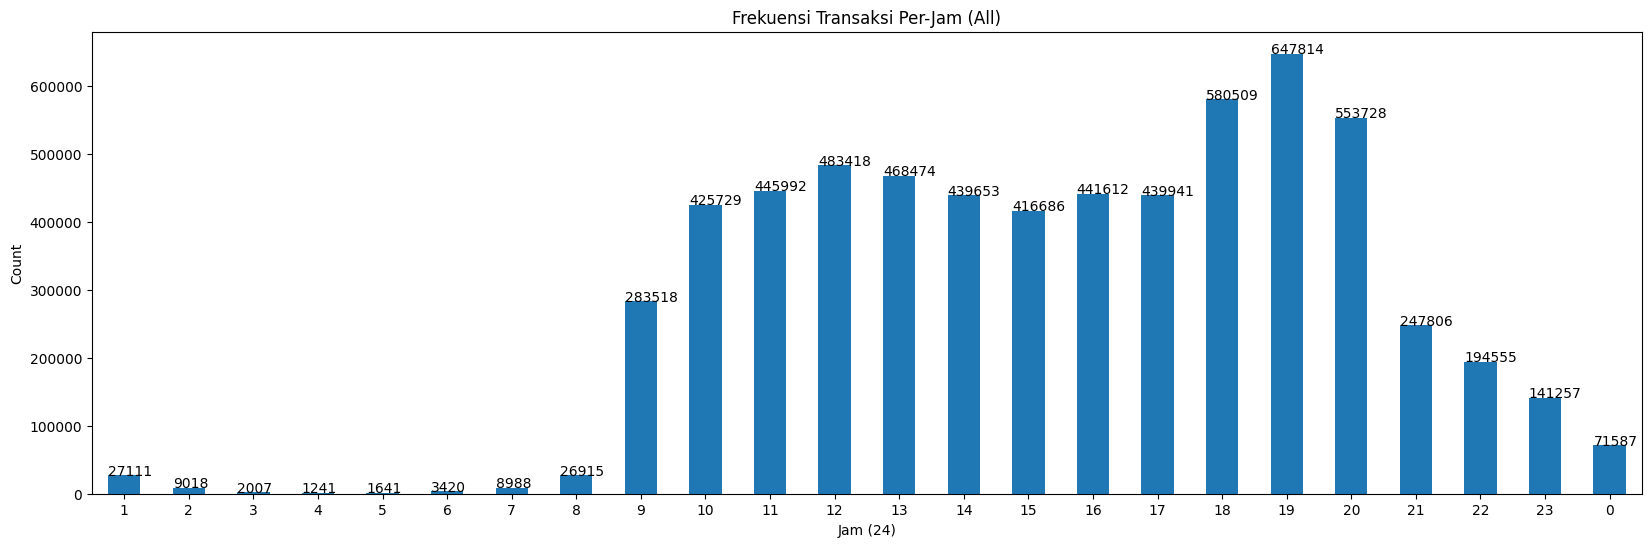

In [34]:
# Distribusi Frekuensi Transaksi Per-Jam (All)

plt.figure(figsize=(20,6))
ax = all_hours.value_counts(sort=False).plot(kind='bar')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))
plt.xlabel('Jam (24)')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yticks()
plt.title('Frekuensi Transaksi Per-Jam (All)')
plt.show()



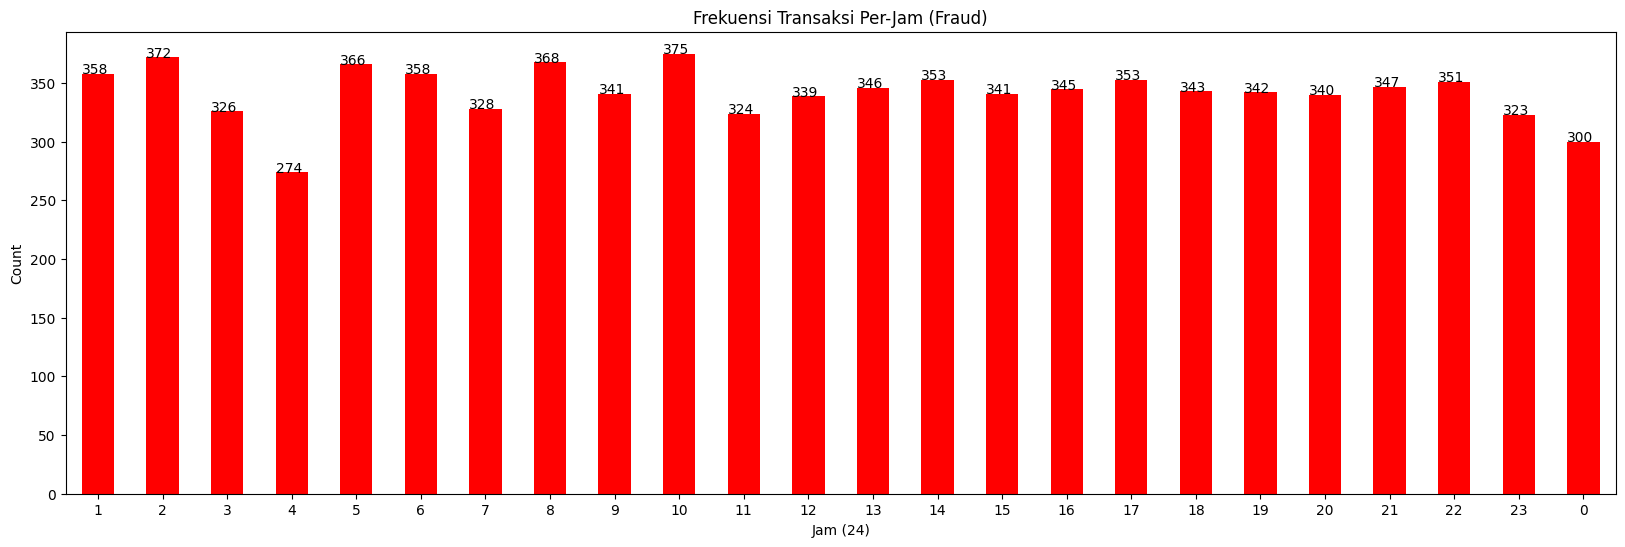

In [35]:
# Distribusi Frekuensi Transaksi Per-Jam (Fraud)

plt.figure(figsize=(20,6))
ax = fraud_hours.value_counts(sort=False).plot(kind='bar',  color='red')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))
plt.xlabel('Jam (24)')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yticks()
plt.title('Frekuensi Transaksi Per-Jam (Fraud)')
plt.show()

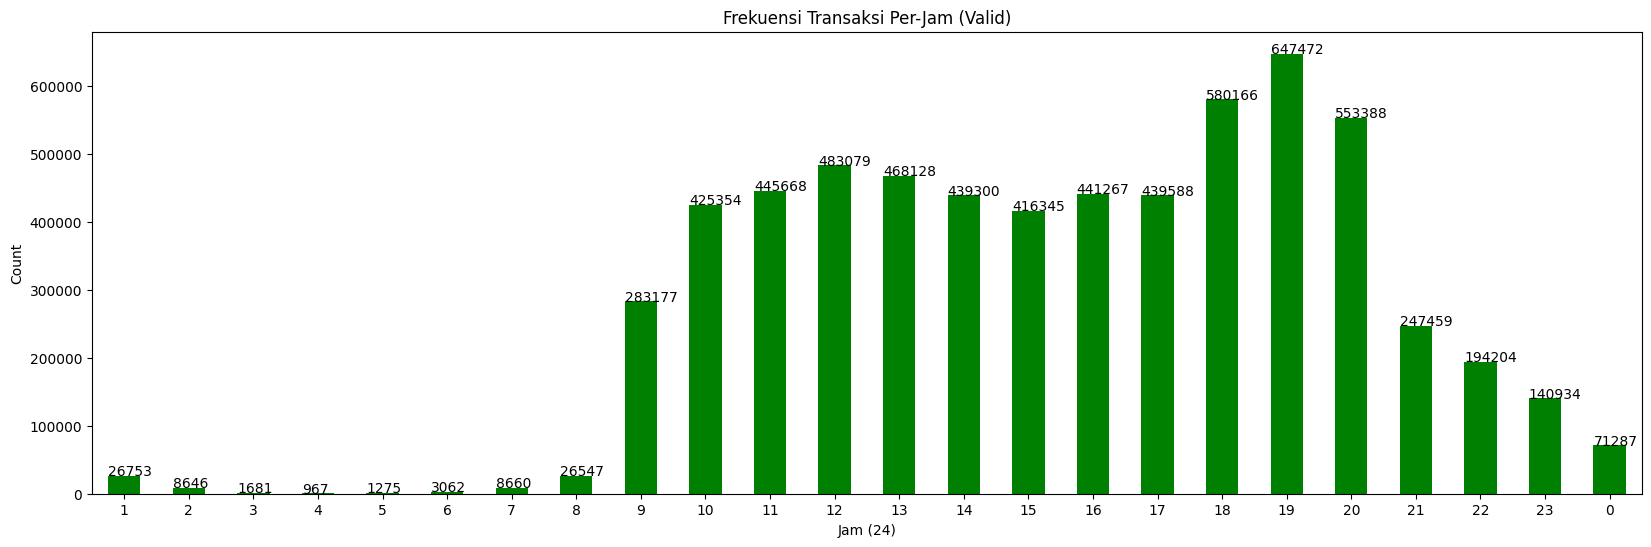

In [36]:
# Distribusi Frekuensi Transaksi Per-Jam (Valid)


plt.figure(figsize=(20,6))
ax = valid_hours.value_counts(sort=False).plot(kind='bar',  color='green')
for i in ax.patches:
    # get_x pulls left or right; get_height pushes up or down
    ax.text(i.get_x(), i.get_height(), str(round(i.get_height(), 2)))
plt.xlabel('Jam (24)')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.yticks()
plt.title('Frekuensi Transaksi Per-Jam (Valid)')
plt.show()

Note:

- Frekuensi transaksi fraud dan valid merata disemua hari
- Frekuensi transaksi fraud lebih merata disemua jam
- Frekuensi transaksi valid lebih tinggi dijam kerja

# Data Preprocessing

In [37]:
# Resampling

y = data.isFraud

print("Sebelum Resampling:")
counts = y.value_counts()
print(counts)

Sebelum Resampling:
isFraud
0    6354407
1       8213
Name: count, dtype: int64


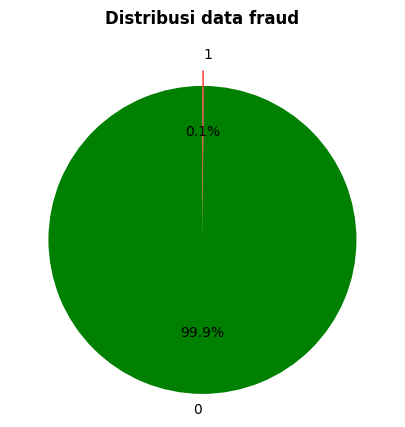

In [38]:
# Membuat pie chart distribusi fraud

plt.figure(figsize=(8, 5))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=["green", "red"], startangle=90, explode=[0.1, 0])
plt.title("Distribusi data fraud", fontweight="bold")
plt.show()

Note:

- Imbalance data terjadi sangat signifikan, yaitu transaksi valid ( 6.354.407-99,9%) dan transaksi fraud (8.213-0,1%)

In [39]:
# Melakukan random udersampling

valid_trans = valid_trans.sample(n=8213) 
data = pd.concat([valid_trans, fraud_trans], axis=0)

In [40]:
# Encoding menggunakan label encoder (Type)

label_encoder = LabelEncoder()

data['type'] = label_encoder.fit_transform(data['type'])

# Cetak mapping kategori ke angka
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping kategori ke angka (type):", mapping)

Mapping kategori ke angka (type): {'CASH_IN': np.int64(0), 'CASH_OUT': np.int64(1), 'DEBIT': np.int64(2), 'PAYMENT': np.int64(3), 'TRANSFER': np.int64(4)}


In [41]:
# Encoding menggunakan label encoder (Type2)

data['type2'] = label_encoder.fit_transform(data['type2'])

# Cetak mapping kategori ke angka
mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping kategori ke angka (type2):", mapping)

Mapping kategori ke angka (type2): {'CC': np.int64(0), 'CM': np.int64(1)}


In [42]:
# Encoding menggunakan label encoder ('nameOrig','nameDest')

data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])


Note:

- Encoding feature type: 
    - CASH_IN : 0
    - CASH_OUT : 1
    - DEBIT : 2 
    - PAYMENT : 3
    - TRANSFER : 4
- Encoding feature type: 
    - CC : 0 
    - CM : 1



In [43]:
data.head()

,step,type,type2,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
3596394,262,3,1,7473.84,13571,16197.0,8723.16,15375,0.00,0.00,0
646392,35,0,0,234813.81,12048,2019.0,236832.81,2468,3349874.75,3115060.94,0
5551193,383,3,1,10029.84,11117,14529.0,4499.16,15319,0.00,0.00,0
3608435,264,2,0,2639.38,10148,50236.0,47596.62,12205,117228.09,119867.47,0
706159,37,1,0,127927.47,13861,0.0,0.00,6569,769808.93,897736.39,0


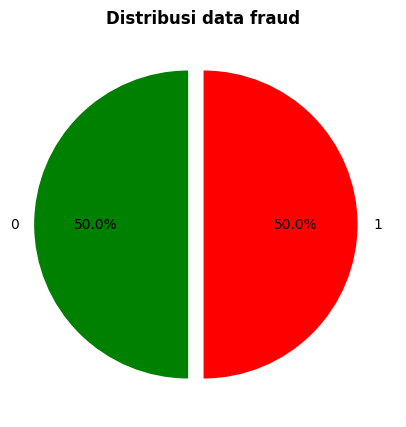

In [44]:
y_resampled = data.isFraud

plt.figure(figsize=(8, 5))
plt.pie(y_resampled.value_counts(), labels=counts.index, autopct='%1.1f%%', colors=["green", "red"], startangle=90, explode=[0.1, 0])
plt.title("Distribusi data fraud", fontweight="bold")
plt.show()

Note: 

- Setelah dilakukan handling imbalace data, data telah proporsional antara transaksi valid ( 8.213-50% ) dan fraud ( 8.213-50% )

In [45]:
print(data.columns)


Index(['step', 'type', 'type2', 'amount', 'nameOrig', 'oldbalanceOrig',
       'newbalanceOrig', 'nameDest', 'oldbalanceDest', 'newbalanceDest',
       'isFraud'],
      dtype='object')


<Axes: title={'center': 'Pearson Corelation'}>

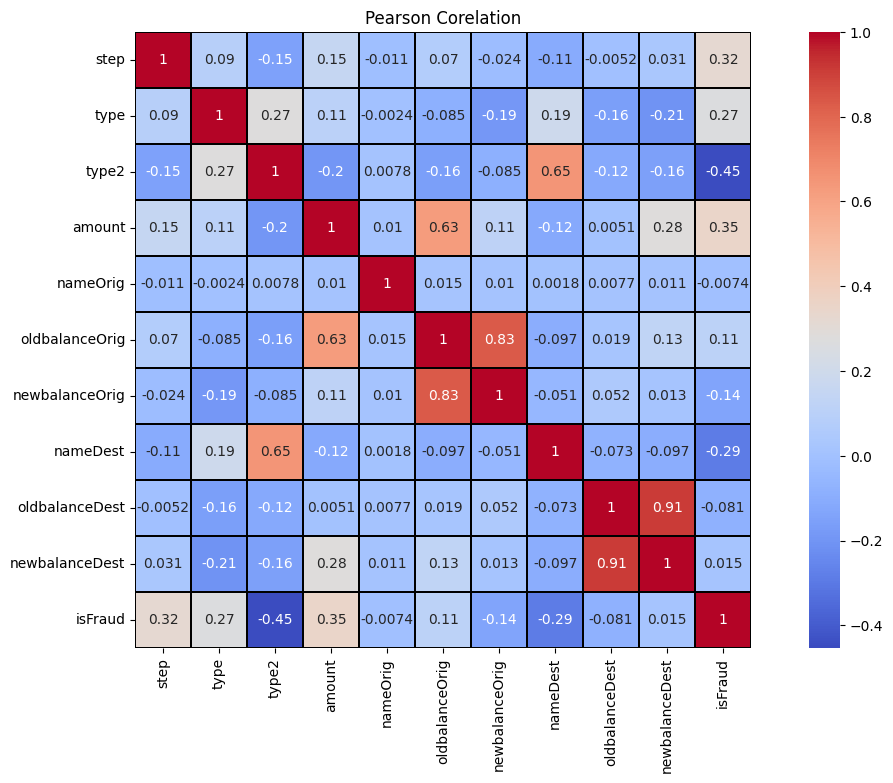

In [46]:
# Memeriksa korelasi variabel setelah encoding dan fitur selection

data = data[['step','type','type2','amount','nameOrig','oldbalanceOrig', 'newbalanceOrig','nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']]
f,ax= plt.subplots(figsize=(15,8))
plt.title("Pearson Corelation")
sns.heatmap(data.astype(float).corr(), linewidth=0.25, vmax=1.0, square=True, cmap="coolwarm", linecolor='black', annot=True)

In [47]:
X = data.drop(columns=['isFraud'], axis=1)
y = data.isFraud

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify=y, random_state=42)

# Standarization

# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [48]:

print(df.shape)
print(X.shape)
print(X_train.shape)


(6362620, 12)
(16426, 10)
(11498, 10)


Note:

- Splitting data dengan data training 70% dan data testing 30%
- Melakukan standarization untuk memaksimalkan kinerja model

# Modeling

### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# model
dtc = DecisionTreeClassifier(random_state=42)

# parameter yang akan diuji
param_grid = {
    "splitter": ["best", "random"],
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "ccp_alpha": [0.0, 0.01, 0.1],
    "max_features": [None, "sqrt", "log2", 0.5, 0.8]
}

# Grid Search dengan Cross Validation 
grid_search = GridSearchCV(dtc, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")


Best Parameters: {'ccp_alpha': 0.0, 'max_depth': 10, 'max_features': 0.8, 'min_samples_leaf': 1, 'min_samples_split': 5, 'splitter': 'best'}
Best Score: 0.9868674092705714


In [ ]:
from sklearn.tree import DecisionTreeClassifier

#CART-Breiman-84-Dasar

dtc = DecisionTreeClassifier(
    splitter="best",
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    random_state=42,
    ccp_alpha=0.0
)


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# model
rfc = RandomForestClassifier(random_state=42)

# parameter yang akan diuji
param_grid_rfc = {
    "n_estimators": [50, 100, 200],  
    "max_depth": [3, 5, 10, None],  
    "min_samples_split": [2, 5, 10],  
    "min_samples_leaf": [1, 2, 4], 
    "bootstrap": [True, False] 
    
    
}

# Grid Search dengan Cross Validation 
grid_search_rfc = GridSearchCV(rfc, param_grid_rfc, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"Best Parameters (Random Forest): {grid_search_rfc.best_params_}")
print(f"Best Score (Random Forest): {grid_search_rfc.best_score_}")


C:\Users\burv\AppData\Roaming\Python\Python311\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters (Random Forest): {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Score (Random Forest): 0.9906073340015507


In [ ]:
#Random Forest-Leo Breiman-01-advance(ensemble)

rfc=RandomForestClassifier(
    max_depth=None,
    min_samples_split = 2,
    min_samples_leaf=1,
    bootstrap=False,
    n_estimators = 50, 
    n_jobs = -1, 
    random_state = 42
 
    )

### XGBoost

In [53]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# model
xgbr = XGBClassifier( eval_metric='logloss', random_state=42)

# parameter yang akan diuji
param_grid_xgbr = {
    "n_estimators": [50, 100, 200],  
    "learning_rate": [0.01, 0.1, 0.2],  
    "max_depth": [3, 5, 10],  
    "gamma": [0, 0.1, 0.2],  
    "reg_alpha": [0, 0.01, 0.1, 1], 
    "reg_lambda": [0, 0.01, 0.1, 1]  
}

# Grid Search dengan Cross Validation 
grid_search_xgbr = GridSearchCV(xgbr, param_grid_xgbr, cv=5, scoring="accuracy", n_jobs=-1)
grid_search_xgbr.fit(X_train, y_train)

# Menampilkan parameter terbaik
print(f"Best Parameters (XGBoost): {grid_search_xgbr.best_params_}")
print(f"Best Score (XGBoost): {grid_search_xgbr.best_score_}")


Best Parameters (XGBoost): {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'reg_alpha': 0.01, 'reg_lambda': 0.01}
Best Score (XGBoost): 0.992085859636515


In [ ]:
#XGBoost-Tianqi Chen-14-advance(GBDT)

xgbr = xgb.XGBClassifier(

    max_depth= 10,  
    learning_rate=0.2,  
    n_estimators=100,  
    objective="binary:logistic", 
    reg_alpha=0.01, 
    reg_lambda=0,  
    n_jobs=-1,  
    random_state=42
    
)

In [55]:
# Train Model
model_dtc = dtc.fit(X_train, y_train)
model_rfc = rfc.fit(X_train, y_train)
model_xgbr = xgbr.fit(X_train, y_train)

In [56]:
import time

models = {'Decision Tree': dtc, 'Random Forest': rfc, 'XGBoost': xgbr}

for name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"Waktu pelatihan {name}: {end_time - start_time:.4f} detik")


Waktu pelatihan Decision Tree: 0.0805 detik
Waktu pelatihan Random Forest: 0.3125 detik
Waktu pelatihan XGBoost: 0.4320 detik


In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16426 entries, 3596394 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  int64  
 2   type2           16426 non-null  int64  
 3   amount          16426 non-null  float64
 4   nameOrig        16426 non-null  int64  
 5   oldbalanceOrig  16426 non-null  float64
 6   newbalanceOrig  16426 non-null  float64
 7   nameDest        16426 non-null  int64  
 8   oldbalanceDest  16426 non-null  float64
 9   newbalanceDest  16426 non-null  float64
 10  isFraud         16426 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 1.5 MB


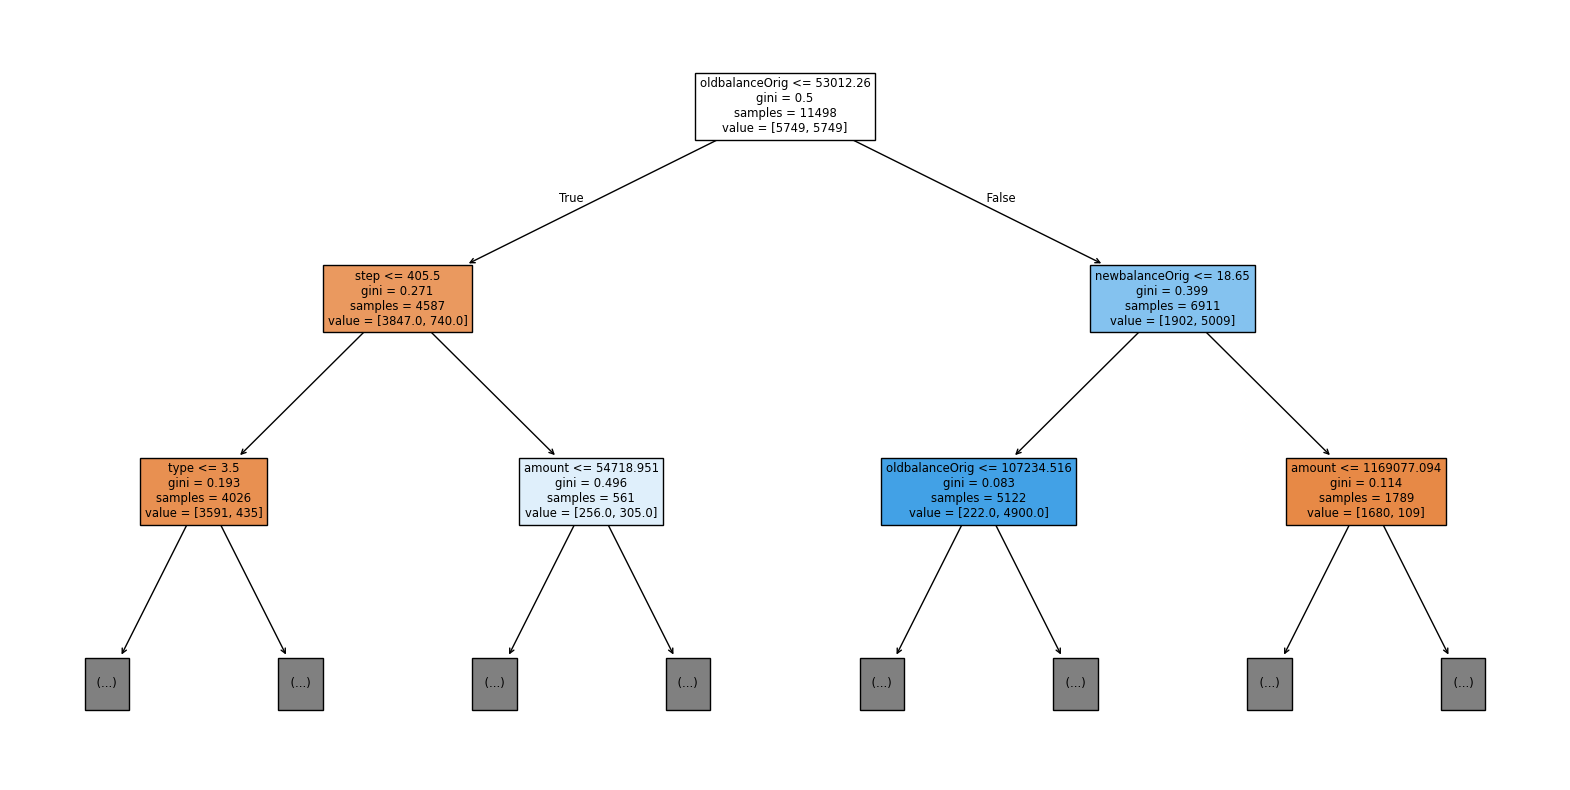

In [58]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))  # Atur ukuran sesuai kebutuhan (lebar, tinggi)

feature_names =  ['step','type','type2','amount','nameOrig','oldbalanceOrig', 'newbalanceOrig','nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud']

# Memvisualisasikan pohon keputusan
plot_tree(model_dtc, feature_names=feature_names,max_depth=2, filled=True)

# Menampilkan plot
plt.show()



In [59]:
# k-Fold Cross-Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=16, shuffle=True, random_state=42)  # 16-Fold
cv_scores_dtc = cross_val_score(model_dtc, X, y, cv=kf, scoring='accuracy')
cv_scores_rfc = cross_val_score(model_rfc, X, y, cv=kf, scoring='accuracy')
cv_scores_xgbr = cross_val_score(model_xgbr, X, y, cv=kf, scoring='accuracy')

# Output hasil
print(f"Accuracy per fold dtc: {cv_scores_dtc}")
print(f"Mean accuracy dtc: {cv_scores_dtc.mean():.4f}")
print(f"Accuracy per fold rfc: {cv_scores_rfc}")
print(f"Mean accuracy rfc: {cv_scores_rfc.mean():.4f}")
print(f"Accuracy per fold xgbr: {cv_scores_xgbr}")
print(f"Mean accuracy xgbr: {cv_scores_xgbr.mean():.4f}")

Accuracy per fold dtc: [0.98442064 0.98636806 0.9902629  0.98831548 0.99415774 0.98539435
 0.99123661 0.98539435 0.9902629  0.98539435 0.98440546 0.98732943
 0.99220273 0.99415205 0.98927875 0.98538012]
Mean accuracy dtc: 0.9884
Accuracy per fold rfc: [0.99123661 0.99123661 0.99318403 0.99610516 0.99123661 0.98831548
 0.99318403 0.99123661 0.99221032 0.98831548 0.99317739 0.99220273
 0.99415205 0.99512671 0.99122807 0.99122807]
Mean accuracy rfc: 0.9921
Accuracy per fold xgbr: [0.99318403 0.99221032 0.99415774 0.99318403 0.99318403 0.99318403
 0.99513145 0.99123661 0.99513145 0.9902629  0.99122807 0.99317739
 0.99512671 0.99707602 0.99512671 0.99512671]
Mean accuracy xgbr: 0.9936


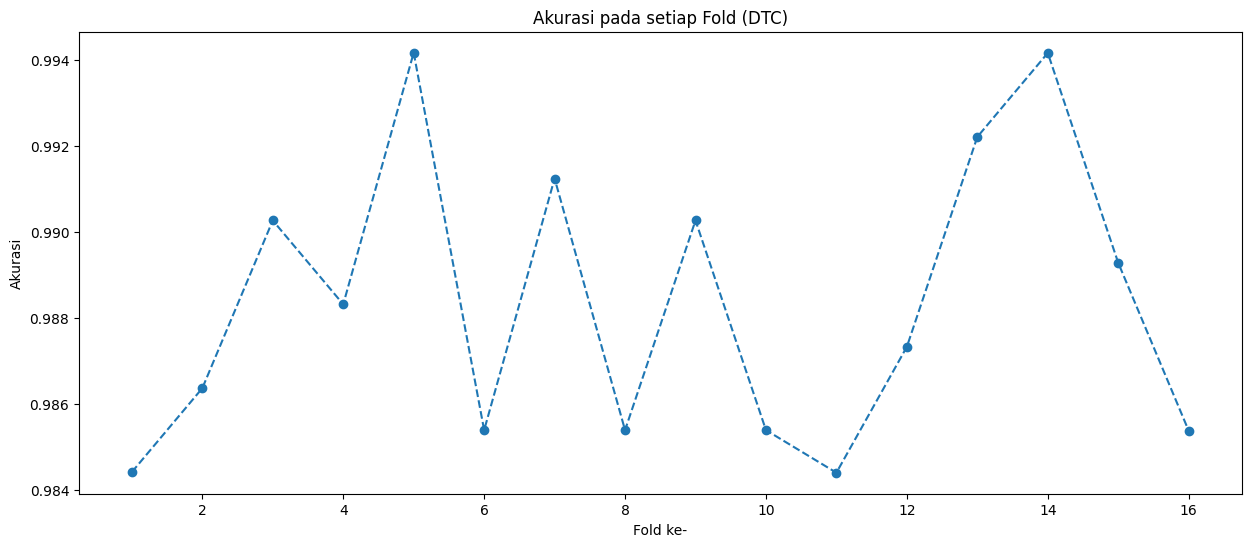

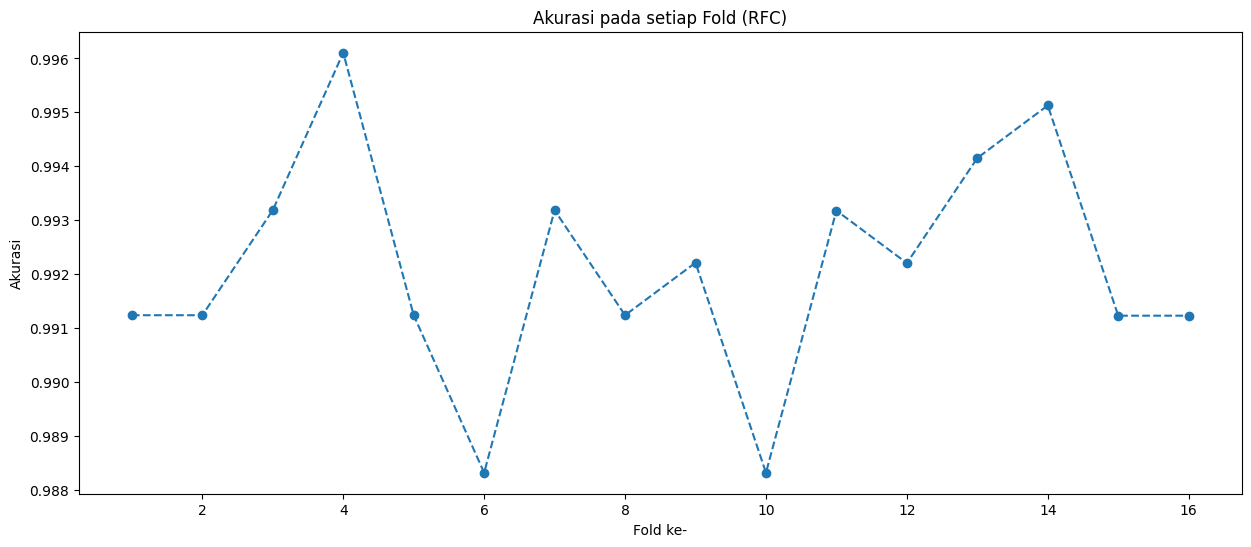

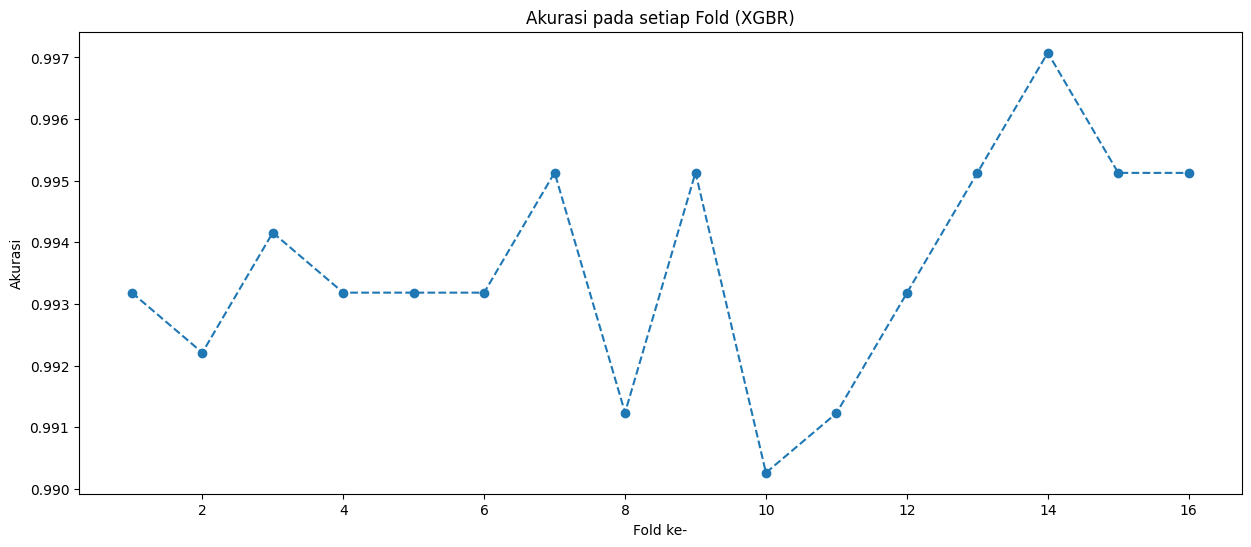

In [60]:
plt.figure(figsize=(15, 6))
plt.plot(range(1, 17), cv_scores_dtc, marker='o', linestyle='--')
plt.title('Akurasi pada setiap Fold (DTC)')
plt.xlabel('Fold ke-')
plt.ylabel('Akurasi')
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(range(1, 17), cv_scores_rfc, marker='o', linestyle='--')
plt.title('Akurasi pada setiap Fold (RFC)')
plt.xlabel('Fold ke-')
plt.ylabel('Akurasi')
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(range(1, 17), cv_scores_xgbr, marker='o', linestyle='--')
plt.title('Akurasi pada setiap Fold (XGBR)')
plt.xlabel('Fold ke-')
plt.ylabel('Akurasi')
plt.show()

In [61]:
# Prediksi
y_pred_dtc = model_dtc.predict(X_test)
y_pred_rfc = model_rfc.predict(X_test)
y_pred_xgbr = model_xgbr.predict(X_test)

# Evaluation

## Evaluation Decision Tree

In [62]:
# evaluasi Klasifikasi
print(classification_report(y_test,y_pred_dtc))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2464
           1       0.98      0.99      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [63]:
accuracy_clf = accuracy_score(y_test, y_pred_dtc)
precision_clf = precision_score(y_test, y_pred_dtc)
recall_clf = recall_score(y_test, y_pred_dtc)
f1_score_clf = f1_score(y_test, y_pred_dtc)
auc_clf = roc_auc_score(y_test, y_pred_dtc)

cm = confusion_matrix(y_test, y_pred_dtc)
true_negative = cm[0, 0]
false_positive = cm[0, 1]
specificity_clf = true_negative / (true_negative + false_positive)

print(f'Accuracy Decision Tree: {accuracy_clf}')
print(f'Precision Decision Tree: {precision_clf}')
print(f'Recall Decision Tree: {recall_clf}')
print(f'Specificity Decision Tree: {specificity_clf}')
print(f'F1 Score Decision Tree: {f1_score_clf}')
print(f'AUC Decision Tree: {auc_clf}')


Accuracy Decision Tree: 0.9878246753246753
Precision Decision Tree: 0.9831189710610932
Recall Decision Tree: 0.9926948051948052
Specificity Decision Tree: 0.9829545454545454
F1 Score Decision Tree: 0.9878836833602584
AUC Decision Tree: 0.9878246753246753


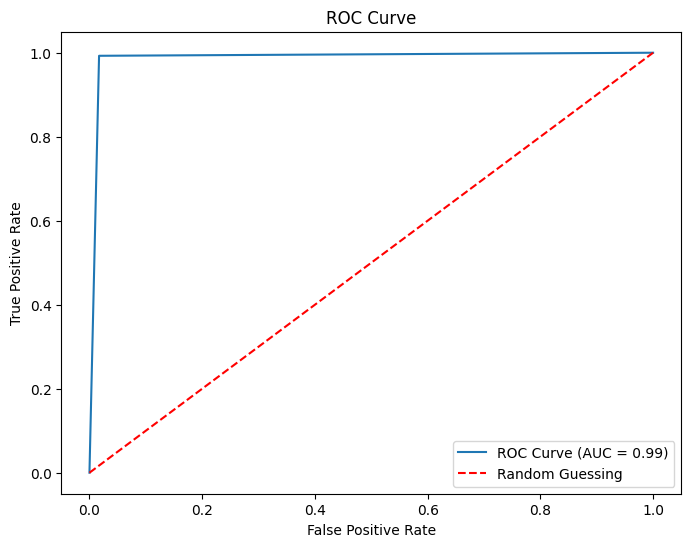

In [64]:
# Kurva ROC DTC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dtc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_clf:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Text(113.9222222222222, 0.5, 'Predict Label')

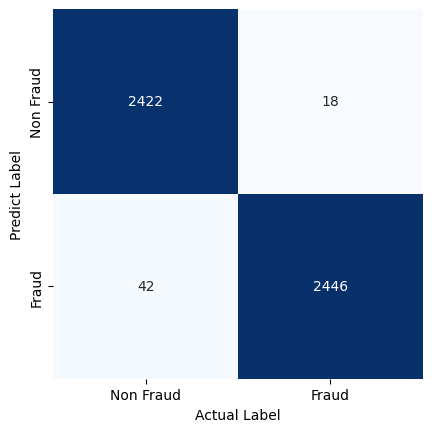

In [65]:
# Memvisualisasikan Confusion Matrix
mat = confusion_matrix(y_test, y_pred_dtc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cmap='Blues', cbar=False, 
            xticklabels=['Non Fraud', 'Fraud'], 
            yticklabels=['Non Fraud', 'Fraud'])
plt.xlabel('Actual Label')
plt.ylabel('Predict Label')

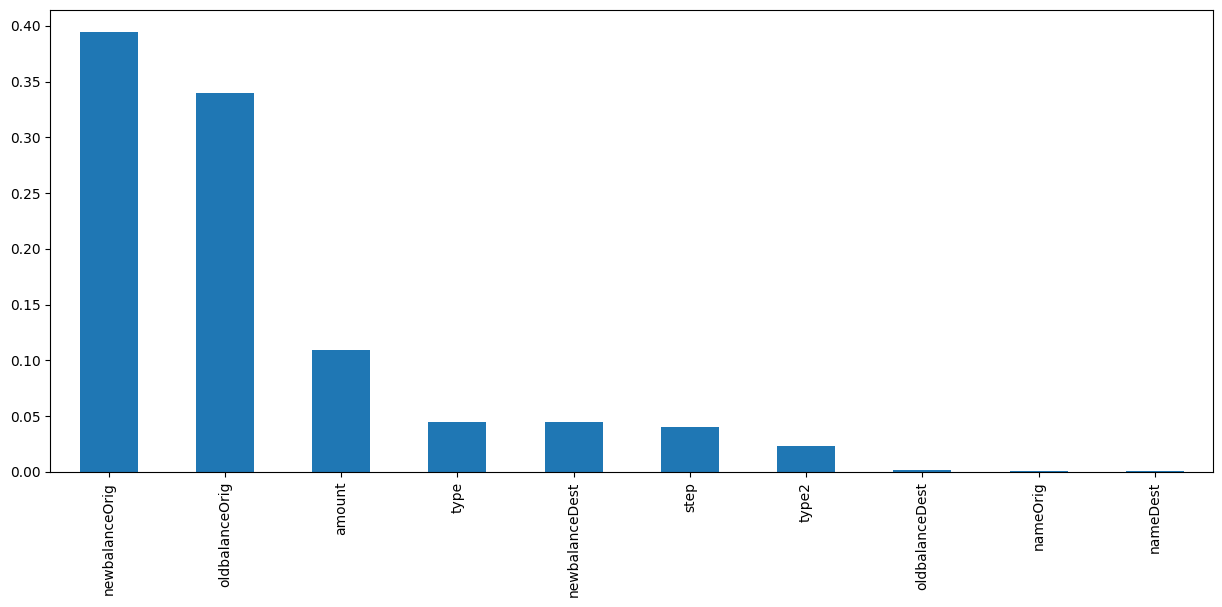

In [66]:
# Signifikan factor model

plt.figure(figsize=(15, 6))
feat_importances = pd.Series(model_dtc.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='bar')
plt.show()

## Evaluation Random Forest

In [67]:
# evaluasi Klasifikasi
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2464
           1       0.99      1.00      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [68]:
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
precision_rfc = precision_score(y_test, y_pred_rfc)
recall_rfc = recall_score(y_test, y_pred_rfc)
f1_score_rfc = f1_score(y_test, y_pred_rfc)
auc_rfc = roc_auc_score(y_test, y_pred_rfc)

cm = confusion_matrix(y_test, y_pred_rfc)
true_negative = cm[0, 0]
false_positive = cm[0, 1]
specificity_rfc = true_negative / (true_negative + false_positive)

print(f'Accuracy Random Forest: {accuracy_rfc}')
print(f'Precision Random Forest: {precision_rfc}')
print(f'Recall Random Forest: {recall_rfc}')
print(f'Specificity Random Forest: {specificity_rfc}')
print(f'F1 Score Random Forest: {f1_score_rfc}')
print(f'AUC Random Forest: {auc_rfc}')

Accuracy Random Forest: 0.9926948051948052
Precision Random Forest: 0.9879421221864951
Recall Random Forest: 0.997564935064935
Specificity Random Forest: 0.9878246753246753
F1 Score Random Forest: 0.9927302100161551
AUC Random Forest: 0.9926948051948051


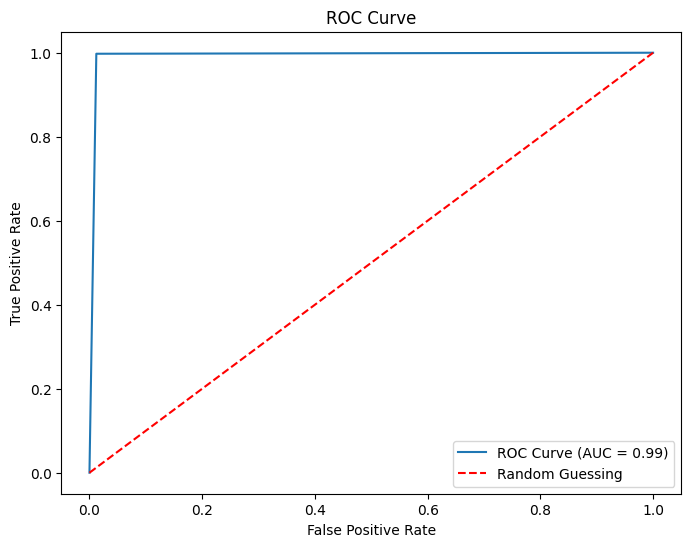

In [69]:
# Kurva ROC DTC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfc)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_rfc:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Text(113.9222222222222, 0.5, 'Predict Label')

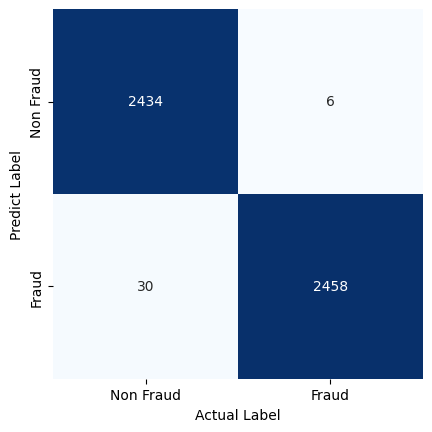

In [70]:
# Memvisualisasikan Confusion Matrix
mat = confusion_matrix(y_test, y_pred_rfc)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cmap='Blues', cbar=False, 
            xticklabels=['Non Fraud', 'Fraud'], 
            yticklabels=['Non Fraud', 'Fraud'])
plt.xlabel('Actual Label')
plt.ylabel('Predict Label')

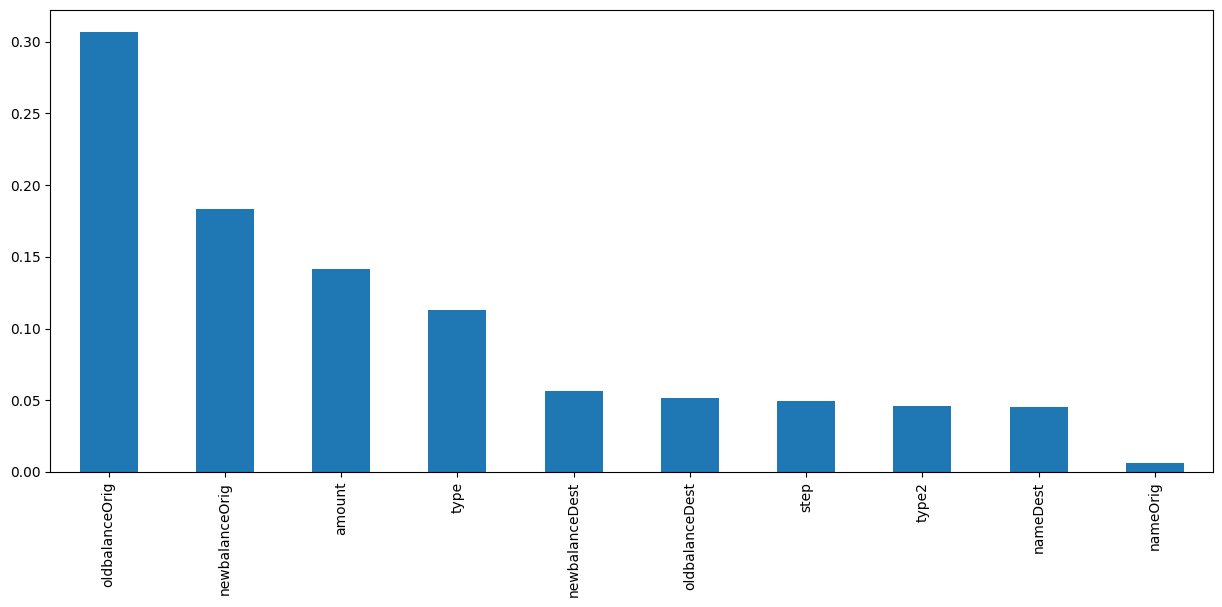

In [ ]:
# Signifikan factor model random Forest

plt.figure(figsize=(15, 6))
feat_importances = pd.Series(model_rfc.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='bar')
plt.show()

## Evaluation XGBoost

In [72]:
# evaluasi Klasifikasi
print(classification_report(y_test,y_pred_xgbr))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2464
           1       0.99      1.00      0.99      2464

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



In [105]:
accuracy_xgbr = accuracy_score(y_test, y_pred_xgbr)
precision_xgbr = precision_score(y_test, y_pred_xgbr)
recall_xgbr = recall_score(y_test, y_pred_xgbr)
f1_score_xgbr = f1_score(y_test, y_pred_xgbr)
auc_xgbr = roc_auc_score(y_test, y_pred_xgbr)

cm = confusion_matrix(y_test, y_pred_xgbr)
true_negative = cm[0, 0]
false_positive = cm[0, 1]
specificity_xgbr = true_negative / (true_negative + false_positive)

print(f'Accuracy XGBoost: {accuracy_xgbr}')
print(f'Precision XGBoost: {precision_xgbr}')
print(f'Recall XGBoost: {recall_xgbr}')
print(f'Specificity XGBoost: {specificity_xgbr}')
print(f'F1 Score XGBoost: {f1_score_xgbr}')
print(f'AUC XGBoost: {auc_xgbr}')

Accuracy XGBoost: 0.9943181818181818
Precision XGBoost: 0.9903381642512077
Recall XGBoost: 0.9983766233766234
Specificity XGBoost: 0.9902597402597403
F1 Score XGBoost: 0.994341147938561
AUC XGBoost: 0.9943181818181819


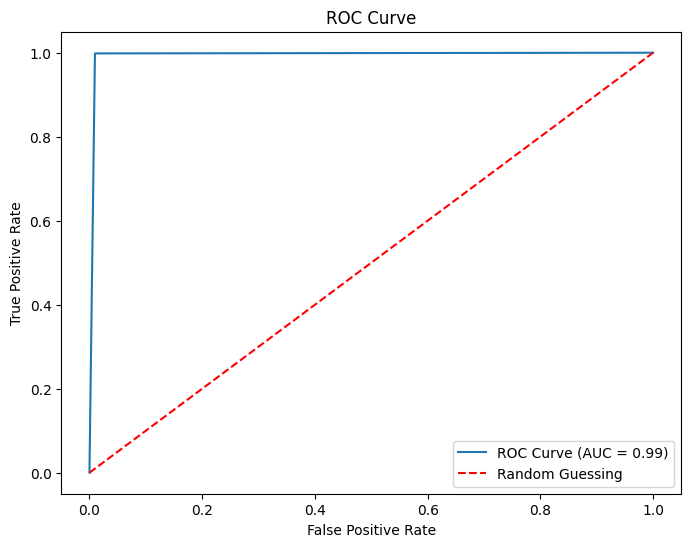

In [74]:
# Kurva ROC DTC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_xgbr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_xgbr:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

Text(113.9222222222222, 0.5, 'Predict Label')

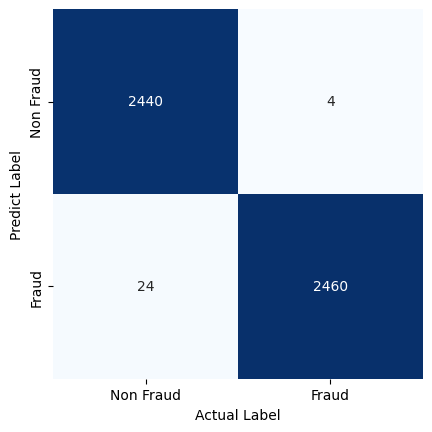

In [75]:
# Memvisualisasikan Confusion Matrix
mat = confusion_matrix(y_test, y_pred_xgbr)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',cmap='Blues', cbar=False, 
            xticklabels=['Non Fraud', 'Fraud'], 
            yticklabels=['Non Fraud', 'Fraud'])
plt.xlabel('Actual Label')
plt.ylabel('Predict Label')

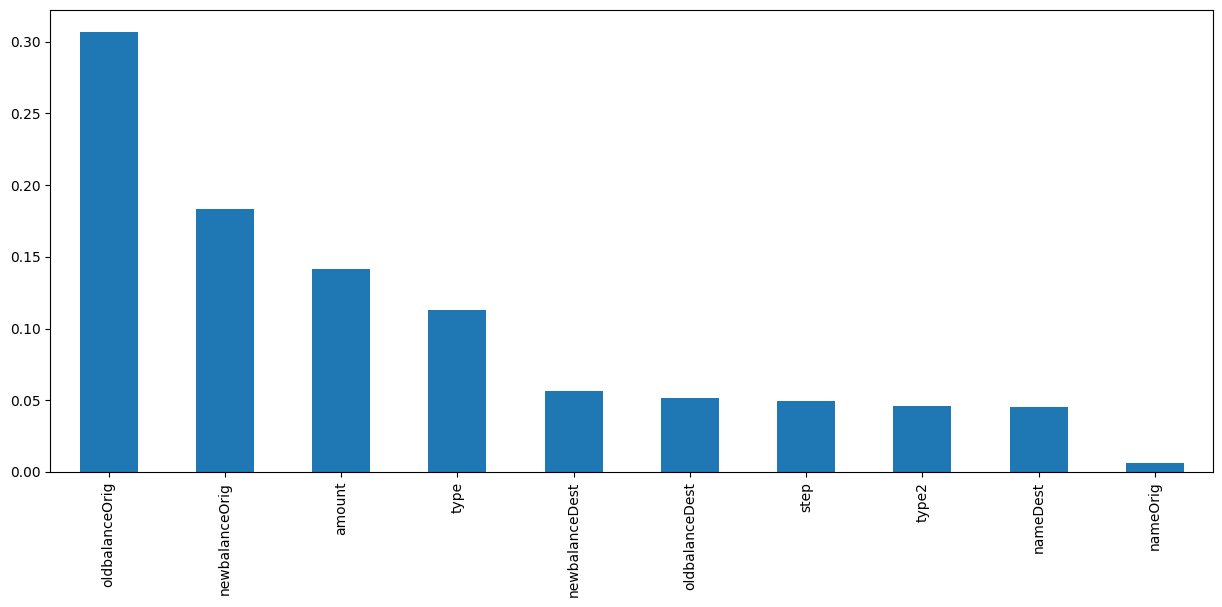

In [ ]:
# Signifikan factor model XGBoost

plt.figure(figsize=(15, 6))
feat_importances = pd.Series(model_rfc.feature_importances_,index=X.columns)
feat_importances.nlargest(10).plot(kind='bar')
plt.show()

## Uji Coba Model

#### Uji coba satuan

In [77]:
data_non = [[235, 196134.48, 1, 0, 2182, 0.00,0.00,4720,2852291.15,3048425.62]]  # Bentuk 2D
data_fraud = [[1,181.00,4,0,2571,181.00,0.0,10331,0.00,0.00]]  # Bentuk 2D

# sc = StandardScaler()
# data_non = sc.fit_transform(data_non)
# data_fraud = sc.fit_transform(data_fraud)

prediksi_baru = model_xgbr.predict(data_fraud)
print(f"Prediksi data baru: {prediksi_baru}")


Prediksi data baru: [0]


#### Uji coba semua data (All)

In [78]:
# Uji Coba Satuan

# Input Varibel
x1=data[['step','type','type2','amount','nameOrig','oldbalanceOrig', 'newbalanceOrig','nameDest', 'oldbalanceDest', 'newbalanceDest']]


# sc = StandardScaler()
# data_non = sc.fit_transform(data_non)
# data_fraud = sc.fit_transform(data_fraud)

prediksi_baru = model_xgbr.predict(x1)
print(f"Prediksi data baru: {prediksi_baru}")


Prediksi data baru: [0 0 0 ... 1 1 1]


In [ ]:
# Mengubah hasil pemodelan yg berbentuk array menjadi Data Frame

df_prediksi_baru = pd.DataFrame({'Prediction Fraud':prediksi_baru})

df_prediksi_baru

,Prediction Fraud
0,0
1,0
2,0
3,0
4,0
...,...
16421,1
16422,1
16423,1
16424,1


In [96]:
# Menggabungkan dataset NewCustomer dan hasil predictnya
path = "./data_test.csv"
df_data_test = pd.read_csv(path)

df_hasil_predict=pd.concat([df_data_test,df_prediksi_baru], sort=False, axis=1)
df_hasil_predict.head()

,step,type,type2,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,Prediction Fraud
0,262,3,1,7473.84,13571,16197.0,8723.16,15375,0.00,0.00,0
1,35,0,0,234813.81,12048,2019.0,236832.81,2468,3349874.75,3115060.94,0
2,383,3,1,10029.84,11117,14529.0,4499.16,15319,0.00,0.00,0
3,264,2,0,2639.38,10148,50236.0,47596.62,12205,117228.09,119867.47,0
4,37,1,0,127927.47,13861,0.0,0.00,6569,769808.93,897736.39,0


### Export Model

In [ ]:
# model 

# import joblib

# pickle.dump(classifier, open("model.pkl", "wb"))
# filename1 = 'model_dtc.joblib'
# joblib.dump(model_dtc, filename1)

# filename2 = 'model_rfc.joblib'
# joblib.dump(model_rfc, filename2)

# filename3 = 'model_xgbr.joblib'
# joblib.dump(model_xgbr, filename3)

['model_xgbr.joblib']

### Export CSV data test

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16426 entries, 3596394 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  int64  
 2   type2           16426 non-null  int64  
 3   amount          16426 non-null  float64
 4   nameOrig        16426 non-null  int64  
 5   oldbalanceOrig  16426 non-null  float64
 6   newbalanceOrig  16426 non-null  float64
 7   nameDest        16426 non-null  int64  
 8   oldbalanceDest  16426 non-null  float64
 9   newbalanceDest  16426 non-null  float64
 10  isFraud         16426 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 1.5 MB


In [ ]:
# data_test = data
# # data_test = data_test.drop(columns=['isFraud'], axis=1)

In [ ]:
# # Ekspor ke file CSV
# data_test.to_csv('data.csv', index=False)  # index=False agar tidak menyertakan indeks
# print("DataFrame berhasil diekspor ke file CSV")

DataFrame berhasil diekspor ke file CSV
